#### Описание датасета
Посмотрим на переменные, которые содержит датасет:

- 1 school — аббревиатура школы, в которой учится ученик
- 2 sex — пол ученика ('F' - женский, 'M' - мужской)
- 3 age — возраст ученика (от 15 до 22)
- 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)
- 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)
- 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
- 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
- 8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
- 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
- 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
- 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
- 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
- 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
- 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
- 15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4)
- 16 schoolsup — дополнительная образовательная поддержка (yes или no)
- 17 famsup — семейная образовательная поддержка (yes или no)
- 18 paid — дополнительные платные занятия по математике (yes или no)
- 19 activities — дополнительные внеучебные занятия (yes или no)
- 20 nursery — посещал детский сад (yes или no)
- 21 higher — хочет получить высшее образование (yes или no)
- 22 internet — наличие интернета дома (yes или no)
- 23 romantic — в романтических отношениях (yes или no)
- 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
- 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
- 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
- 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
- 28 absences — количество пропущенных занятий
- 29 score — баллы по госэкзамену по математике

# 1. Загружаем библиотеки

In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [281]:
pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

## 1.1. Пишем полезные функции

In [282]:
def percent(a,c):
    result = str(round(a/c*100,1)) + '%'
    return result

In [283]:
def outliers(s, outliers, k = 1.5):
    median = s.median()
    IQR = s.quantile(0.75) - s.quantile(0.25)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    top = Q3 + k*IQR
    down = Q1 - k*IQR
    out_top = s[s > top]
    out_down = s[s < down]
    
    if outliers == 'top':
        result = out_top
    elif outliers == 'down':
        result = out_down

    return result

In [284]:
def mode_change(df, A, B):
    # находим уникальные значения в столбце B
    keys = list(df[B].value_counts().index)
    
    #создаём словарь где ключ это уникальное значение из столбца B, а значение - мода по столбцу А
    dict_mode = {}
    for key in keys:
        dict_mode[key] = df[df[B] == key][A].mode()[0]

    #найдём моду в B
    mode_B = df[B].mode()[0]    
        
    #разбираемся с пропусками в А, где в B пропусков нет
    index_1 = [x[0] for x in df[(df[A].isnull())&(df[B].notnull())].iterrows()]
         
    for i in index_1:
        print(i, df.loc[i, A],' -> ', dict_mode[df[B][i]])
        df.loc[i, A] = dict_mode[df[B][i]]
    
    #разбираемся с пропусками в А, где в B пропуски
    index_2 = [x[0] for x in df[(df[A].isnull())&(df[B].isnull())].iterrows()]
    for i in index_2:
        print(i, df.loc[i, A],' -> ', dict_mode[mode_B])
        df.loc[i, A] = dict_mode[mode_B]

In [285]:
# Функция для проверки статистической разницы в распределении оценок по номинативным признакам
# с помощью теста Стьюдента встроенного в функцию ttest_ind()

def get_stat_dif(column, score):
    # На входе имеем имя столбца с нечисловыми (номинативными) данными
    # Проверяем характер распределения оценок в зависимости от значений в этом столбце
    
    # Выбираем 10 самых частотных варианта для текущего столбца
    cols = df.loc[:, column].value_counts().index #[:10] 
    
    # Создаём все возможные парные комбинации из элементов списка cols 
    # Например пара компаний:'Soma', 'Fresco'
    combinations_all = list(combinations(cols, 2))
    
    # Для каждой пары номинативных значений рассматриваемого столбца
    # выполняем тест Стьюдента с поправкой Бонферони
    for comb in combinations_all:
                
        # Готовим аргументы для функции ttest_ind()
        argument0 = df.loc[df.loc[:, column] == comb[0], score] #Например: оценки по продукции компании 'Soma'
        argument1 = df.loc[df.loc[:, column] == comb[1], score] #Например: оценки по продукции компании 'Fresco'
        
        
        if ttest_ind(argument0, argument1, nan_policy = 'omit').pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            
            # Выводим наименования интересующих нас столбцов
            print('Походу столбец ', score,' взаимосвязан со столбцом ', column)
            break

### Замена некорректных данных на None

In [286]:
def nn(column):
    df[column] = df[column].apply(lambda x: None if pd.isnull(x)  # заменяем все виды нулей на None
                                  else None if x == 'nan'         # заменяем nan на None   
                                  else x                          # остальное оставляем как есть
                                  )

In [287]:
def change_this(column, arg1, arg2):
    df[column] = df[column].apply(lambda x: arg2 if x == arg1  
                                   else x                          
                                  )

# 2. Загружаем датасет

In [288]:
df = pd.read_csv('stud_math.csv')

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

## 2.1 Лишний столбец? ('studytime, granular')

##### В описании указывалось 29 столбцов данных. В загружаемом массиве - 30. Проанализируем столбцы: 'studytime' и 'studytime, granular'

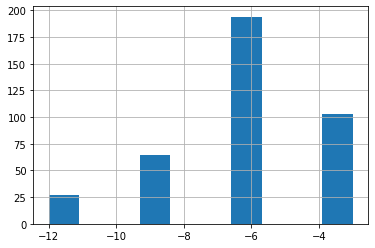

In [290]:
df['studytime, granular'].hist()

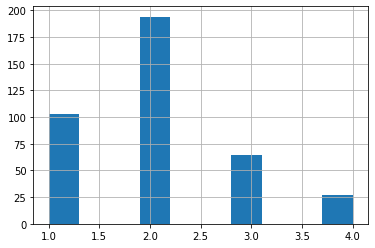

In [291]:
df['studytime'].hist()

##### Данные очень схожи. Умножим один из столбцов на -1/3 и сверим данные по гистограммам

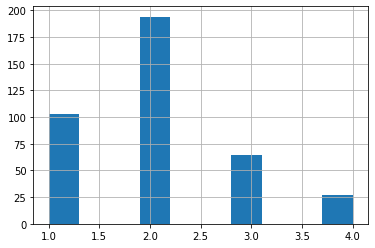

In [292]:
(df['studytime, granular']*(-1/3)).hist()

##### Визуально данные идентичны, найдём коэффициент корреляции

In [293]:
df[['studytime, granular', 'studytime']].corr()

,"studytime, granular",studytime
"studytime, granular",1.0,-1.0
studytime,-1.0,1.0


##### Удалим столбец df['studytime, granular'], т.к. эти данные дублируют данные df['studytime'] (с коэф. -1/3)

In [294]:
df.drop(['studytime, granular'], axis = 'columns', inplace = True)

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       378 non-null object
famsize       368 non-null object
Pstatus       350 non-null object
Medu          392 non-null float64
Fedu          371 non-null float64
Mjob          376 non-null object
Fjob          359 non-null object
reason        378 non-null object
guardian      364 non-null object
traveltime    367 non-null float64
studytime     388 non-null float64
failures      373 non-null float64
schoolsup     386 non-null object
famsup        356 non-null object
paid          355 non-null object
activities    381 non-null object
nursery       379 non-null object
higher        375 non-null object
internet      361 non-null object
romantic      364 non-null object
famrel        368 non-null float64
freetime      384 non-null float64
goout         387 non-null float64
heal

## 2.2 Работа с пропусками в первом приближении

##### Проверим самый простой способ очистки данных - удалить все строки с пропусками

In [296]:
df.dropna(axis = 0, how = 'any', inplace = False).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 4 to 391
Data columns (total 29 columns):
school        97 non-null object
sex           97 non-null object
age           97 non-null int64
address       97 non-null object
famsize       97 non-null object
Pstatus       97 non-null object
Medu          97 non-null float64
Fedu          97 non-null float64
Mjob          97 non-null object
Fjob          97 non-null object
reason        97 non-null object
guardian      97 non-null object
traveltime    97 non-null float64
studytime     97 non-null float64
failures      97 non-null float64
schoolsup     97 non-null object
famsup        97 non-null object
paid          97 non-null object
activities    97 non-null object
nursery       97 non-null object
higher        97 non-null object
internet      97 non-null object
romantic      97 non-null object
famrel        97 non-null float64
freetime      97 non-null float64
goout         97 non-null float64
health        97 non-null float

In [297]:
percent(97,395)

'24.6%'

##### Остаётся меньше четверти данных. Значит сначала нужно избавиться от лишних столбцов и рассмотреть возможность заполнения пропусков.

## 2.3 Проанализируем имена столбцов

In [298]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

#### Имена столбцов не требуют редактирования и будут удобны для работы в том виде в котором есть.

## 2.4 Разделим данные на количественные и номинативные

In [299]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [300]:
all_columns = list(df.columns)

In [301]:
num_columns = (['age',
                'absences',
                'score',
                'failures'])
num_columns

['age', 'absences', 'score', 'failures']

In [302]:
nonn_columns = set(df.columns) - set(num_columns)

In [303]:
nonn_columns = list(nonn_columns)
nonn_columns

['sex',
 'romantic',
 'school',
 'higher',
 'guardian',
 'goout',
 'famsize',
 'address',
 'Medu',
 'internet',
 'Fjob',
 'health',
 'freetime',
 'Fedu',
 'activities',
 'schoolsup',
 'Mjob',
 'studytime',
 'famsup',
 'traveltime',
 'reason',
 'famrel',
 'paid',
 'nursery',
 'Pstatus']

In [304]:
len(nonn_columns)

25

##### Также можно выделить ранговые переменные

In [305]:
rank_columns = (['famsize',
                 'Medu',
                 'Fedu',
                 'traveltime',
                 'studytime',
                 'famrel',
                 'freetime',
                 'goout',
                 'health'             
                 ])

In [306]:
len(rank_columns)

9

In [307]:
nonr_columns = list(set(nonn_columns) - set(rank_columns))

#### Заменим все пропуски на None

In [308]:
for col in all_columns:
    nn(col)

## 2.5 Резюме по разделу 2

- удалили столбец df['studytime, granular'], т.к. эти данные дублируют данные df['studytime'] (с коэф. -1/3)
- удаление строк с пустыми ячейками на данном этапе не целоесообразно

В датасете осталось
- 395 строк, 97 из которых не содержат пропусков
- 4 количественных столбцов, 1 из которых не содержит пропусков (age). Создали спсисок имён этих столбцов (num_columns)
- 25 номинативных, 2 из которых не содержат пропусков (school, sex). Создали спсисок имён этих столбцов (nonn_columns)
- 9 ранговых (из числа номинативных). Создали спсисок имён этих столбцов (rank_columns)
- все имена столбцов в удобном для работы виде


# 3. Рассмотрим количественные данные

In [309]:
df_n = df[num_columns] # количественные данные

df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 4 columns):
age         395 non-null int64
absences    383 non-null float64
score       389 non-null float64
failures    373 non-null float64
dtypes: float64(3), int64(1)
memory usage: 12.5 KB


## 3.1 Работа с пропусками удалением

In [310]:
df_n_wn = df_n.dropna(axis = 0, how = 'any', inplace = False)
df_n_wn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 394
Data columns (total 4 columns):
age         356 non-null int64
absences    356 non-null float64
score       356 non-null float64
failures    356 non-null float64
dtypes: float64(3), int64(1)
memory usage: 13.9 KB


##### При слепом удалении потеряем 10% данных. Попробуем провести корреляционный анализ. 
##### Если сможем найти скоррелированные столбцы и удалить часть из них, то очистка исходных данных (df_n) скорее всего
##### будет с меньшими потерями (менее 10 %)

##### Однако думаю стоит удалить строки с пропусками в столбце 'score'. Так как это целевая переменная и заполняя пропуски по ней мы сильно исказим нашу модель. Потери данных после удаления составят 1,5%.

In [311]:
df_n_wn = df_n.dropna(subset = ['score'], how = 'any', inplace = False)
df_n_wn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 4 columns):
age         389 non-null int64
absences    378 non-null float64
score       389 non-null float64
failures    367 non-null float64
dtypes: float64(3), int64(1)
memory usage: 15.2 KB


In [312]:
df.dropna(subset = ['score'], how = 'any', inplace = True)

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
school        389 non-null object
sex           389 non-null object
age           389 non-null int64
address       374 non-null object
famsize       362 non-null object
Pstatus       344 non-null object
Medu          386 non-null float64
Fedu          365 non-null float64
Mjob          370 non-null object
Fjob          353 non-null object
reason        372 non-null object
guardian      358 non-null object
traveltime    361 non-null float64
studytime     382 non-null float64
failures      367 non-null float64
schoolsup     380 non-null object
famsup        351 non-null object
paid          350 non-null object
activities    375 non-null object
nursery       374 non-null object
higher        369 non-null object
internet      355 non-null object
romantic      358 non-null object
famrel        362 non-null float64
freetime      380 non-null float64
goout         382 non-null float64
heal

## 3.2 Рассмотрим все 4 количественных столбца по одному

### 3.2.1 'age' - возраст

In [314]:
print(df.age.value_counts(dropna = False))

16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F84EF5C48>]],
      dtype=object)

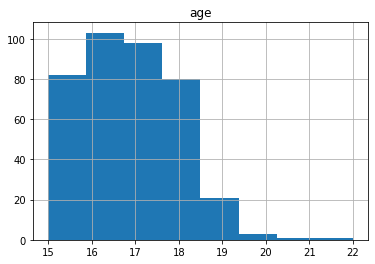

In [315]:
df.hist(column = 'age', bins = len(df.age.value_counts()))

##### Данные выглядят хорошо: пропусков нет, распределение без выбросов, возрастной диапазон (16-22) адекватен.

### 3.2.2 'absences' - пропуски занятий

In [316]:
len(df[df.absences.isnull()])

11

##### Имеем 11 пропусков данных. Посмотрим на распределение данных

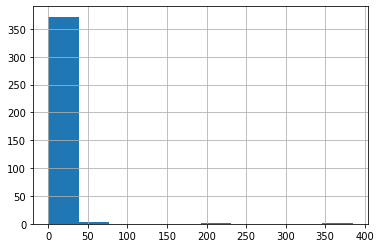

In [317]:
df.absences.hist()

In [318]:
ind = list(df.absences.value_counts(dropna = True).index)
ind.sort()
print(ind)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 38.0, 40.0, 54.0, 56.0, 75.0, 212.0, 385.0]


##### Данные имееют очень большой размах, что может негативно отразиться на нашей моделе. Попробуем избавиться от "хвостов". А точнее от "хвоста" справа

##### Воспользуемся формулой интерквартильного расстояния для определения выбросов

In [319]:
outliers(df.absences, 'top', k = 1.5)

40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64

In [320]:
outliers(df.absences, 'top', k = 1.5).min()

21.0

In [321]:
len(outliers(df.absences, 'top', k = 1.5))

17

In [322]:
percent(17, len(df.absences))

'4.4%'

##### По формуле интерквартильного размаха получаем довольно много выбросов - 4.4 %. Думаю стоит отсечь минимальный хвост, без которого график распределения прогулов будет выглядет относительно плавно.

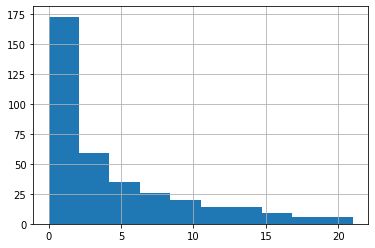

In [323]:
df.absences[(df.absences <= 21)].hist() # Грфик без хвоста > 21 пропусков

In [324]:
outliers(df.absences, 'top', k = 6).min()

75.0

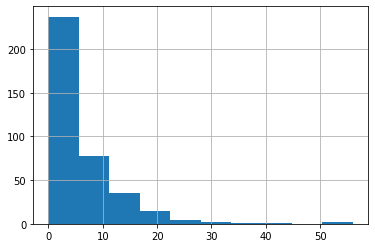

In [325]:
df.absences[(df.absences < 75)].hist()

In [326]:
df[['age','schoolsup','famsup','absences', 'score']][(df.absences >=75)]

,age,schoolsup,famsup,absences,score
222,16,yes,None,385.0,85.0
276,18,no,None,75.0,45.0
390,20,no,yes,212.0,45.0


##### Строка 222 явно выбивается из общих данных. Довольно высокий балл за экзамен и очень много прогулов. Видимо данный ученик на специальных условиях (домашнее обучение или т.п.). Данную строчку следует удалить.

In [327]:
df.drop([222], inplace = True)

In [328]:
df[['age','schoolsup','famsup','absences', 'score']][(df.absences >= 54)]

,age,schoolsup,famsup,absences,score
74,16,yes,yes,54.0,55.0
183,17,no,yes,56.0,40.0
276,18,no,None,75.0,45.0
390,20,no,yes,212.0,45.0


In [329]:
df.drop([390, 276], inplace = True)

##### Также удалим оставшиеся два крайних значения. Строки 390 и 276.

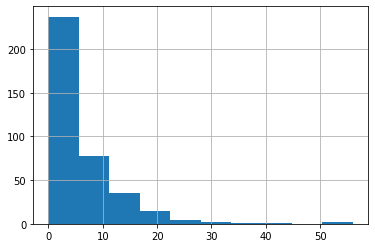

In [330]:
df.absences.hist()

##### Рассмотрим пропуски в данных.

In [331]:
df[df.absences.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
24,GP,F,15,R,GT3,T,2.0,4.0,services,health,course,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,NaN,40.0
101,GP,M,16,U,GT3,T,4.0,4.0,services,teacher,other,father,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,4.0,3.0,4.0,NaN,85.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,None,course,mother,1.0,2.0,0.0,no,no,no,no,no,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
129,GP,M,16,R,None,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
150,GP,M,18,U,LE3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,yes,no,yes,yes,2.0,3.0,5.0,4.0,NaN,0.0
172,GP,M,17,U,None,T,4.0,4.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,4.0,4.0,5.0,NaN,50.0
215,GP,F,17,U,LE3,T,3.0,2.0,other,other,reputation,mother,2.0,2.0,0.0,no,no,None,no,yes,yes,None,no,4.0,4.0,4.0,1.0,NaN,75.0
227,GP,M,17,U,LE3,None,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,None,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
254,GP,M,17,None,None,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
265,GP,M,18,R,LE3,None,3.0,4.0,None,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,2.0,5.0,1.0,NaN,85.0


##### Заменим NaN на модовские значения с аналогичным баллом.

In [332]:
mode_change(df, 'absences', 'score')

24 nan  ->  0.0
101 nan  ->  0.0
120 nan  ->  0.0
129 nan  ->  0.0
150 nan  ->  0.0
172 nan  ->  4.0
215 nan  ->  0.0
227 nan  ->  0.0
254 nan  ->  0.0
265 nan  ->  0.0
352 nan  ->  0.0


In [333]:
df[df.absences.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score


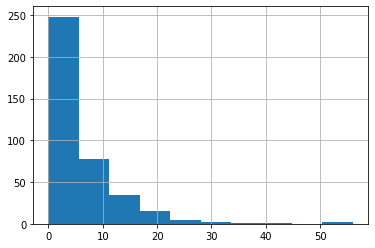

In [334]:
df.absences.hist()

In [335]:
num_columns

['age', 'absences', 'score', 'failures']

### 3.2.3 'failures' - количество внеучебных неудач (n, если 1<=n<3, иначе 4)

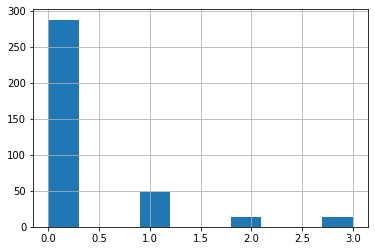

In [336]:
df.failures.hist()

In [337]:
df.failures.value_counts(dropna = False)

0.0    288
1.0     48
NaN     22
2.0     14
3.0     14
Name: failures, dtype: int64

In [338]:
df[['failures','absences','score']][df.failures.isnull()]

,failures,absences,score
21,NaN,0.0,75.0
48,NaN,2.0,70.0
54,NaN,6.0,65.0
68,NaN,2.0,40.0
91,NaN,4.0,90.0
107,NaN,2.0,90.0
108,NaN,6.0,65.0
114,NaN,8.0,45.0
115,NaN,2.0,80.0
125,NaN,0.0,60.0


##### Заменим пропуски на модовский значения пропусков среди учеников с тем же балом

In [339]:
mode_change(df, 'failures', 'score')

21 nan  ->  0.0
48 nan  ->  0.0
54 nan  ->  0.0
68 nan  ->  0.0
91 nan  ->  0.0
107 nan  ->  0.0
108 nan  ->  0.0
114 nan  ->  0.0
115 nan  ->  0.0
125 nan  ->  0.0
153 nan  ->  0.0
158 nan  ->  0.0
170 nan  ->  0.0
171 nan  ->  0.0
204 nan  ->  0.0
214 nan  ->  0.0
236 nan  ->  0.0
261 nan  ->  0.0
280 nan  ->  0.0
313 nan  ->  0.0
320 nan  ->  0.0
344 nan  ->  0.0


In [340]:
df.failures.value_counts(dropna = False)

0.0    310
1.0     48
2.0     14
3.0     14
Name: failures, dtype: int64

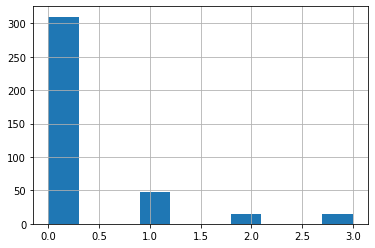

In [341]:
df.failures.hist()

### 3.2.4 'score' -  баллы по госэкзамену по математике

In [342]:
df[df.score.isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score


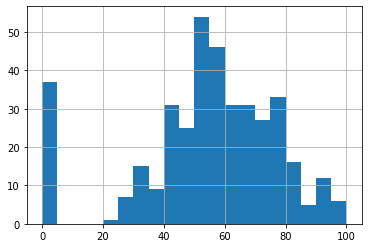

In [343]:
df.score.hist(bins = 20)

In [344]:
df.score.describe()

count    386.000000
mean      52.215026
std       22.941549
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

##### Ученики, которые получили 0 баллов за экзамен явно выделяются на фоне остальных учеников. Те кто получил 0 баллов, скорее всего не сдавали экзамен по каким-то причинам. 

##### Диапазон значений в ожидаемых пределах (от 0 до 100). Пропуски мы удалили ранее

In [345]:
df[num_columns].corr()

,age,absences,score,failures
age,1.000000,0.161288,-0.152866,0.194331
absences,0.161288,1.000000,0.034301,0.077257
score,-0.152866,0.034301,1.000000,-0.337613
failures,0.194331,0.077257,-0.337613,1.000000


##### Полностью скоррелированных данных среди количественных параметров нет.

# 4. Рассмотрим номинативные данные

In [346]:
df[nonn_columns]

,sex,romantic,school,higher,guardian,goout,famsize,address,Medu,internet,Fjob,health,freetime,Fedu,activities,schoolsup,Mjob,studytime,famsup,traveltime,reason,famrel,paid,nursery,Pstatus
0,F,no,GP,yes,mother,4.0,None,U,4.0,None,teacher,3.0,3.0,4.0,no,yes,at_home,2.0,no,2.0,course,4.0,no,yes,A
1,F,no,GP,yes,father,3.0,GT3,U,1.0,yes,other,3.0,3.0,1.0,no,no,at_home,2.0,yes,1.0,course,5.0,no,no,None
2,F,None,GP,yes,mother,2.0,LE3,U,1.0,yes,other,3.0,3.0,1.0,no,yes,at_home,2.0,no,1.0,other,4.0,None,yes,T
3,F,yes,GP,yes,mother,2.0,GT3,U,4.0,yes,None,5.0,2.0,2.0,yes,no,health,3.0,yes,1.0,home,3.0,yes,yes,T
4,F,no,GP,yes,father,2.0,GT3,U,3.0,no,other,5.0,3.0,3.0,no,no,other,2.0,yes,1.0,home,4.0,yes,yes,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,F,no,MS,yes,mother,1.0,GT3,U,1.0,None,other,5.0,1.0,1.0,yes,no,other,2.0,no,NaN,course,1.0,no,yes,T
391,M,no,MS,yes,mother,5.0,LE3,U,3.0,yes,services,2.0,4.0,1.0,no,no,services,1.0,no,2.0,course,2.0,no,no,T
392,M,no,MS,None,None,3.0,GT3,R,1.0,no,other,3.0,5.0,1.0,no,None,other,1.0,no,1.0,course,5.0,no,no,T
393,M,no,MS,yes,mother,1.0,LE3,R,3.0,yes,other,5.0,4.0,2.0,None,no,services,1.0,no,3.0,course,4.0,no,no,T


##### Выполним первичную проверку Стьюденда

In [347]:
for col in nonn_columns:
    get_stat_dif(col,'score')
    

Походу столбец  score  взаимосвязан со столбцом  sex
Походу столбец  score  взаимосвязан со столбцом  romantic
Походу столбец  score  взаимосвязан со столбцом  higher
Походу столбец  score  взаимосвязан со столбцом  goout
Походу столбец  score  взаимосвязан со столбцом  address
Походу столбец  score  взаимосвязан со столбцом  Medu
Походу столбец  score  взаимосвязан со столбцом  Mjob


In [350]:
for col in rank_columns:
    get_stat_dif(col,'score')

Походу столбец  score  взаимосвязан со столбцом  Medu
Походу столбец  score  взаимосвязан со столбцом  goout


##### Посмотрим на корреляци колличественных и ранговых параметров

In [351]:
df[num_columns+rank_columns].corr()

,age,absences,score,failures,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,health
age,1.000000,0.161288,-0.152866,0.194331,-0.145246,-0.130636,0.075437,-0.018066,0.049916,0.009784,0.120651,-0.074919
absences,0.161288,1.000000,0.034301,0.077257,0.107271,0.014838,-0.028904,-0.067890,-0.051014,-0.016713,0.081597,-0.043981
score,-0.152866,0.034301,1.000000,-0.337613,0.216458,0.077687,-0.068226,0.116182,0.067082,0.019789,-0.125199,-0.068139
failures,0.194331,0.077257,-0.337613,1.000000,-0.238579,-0.148524,0.047989,-0.172130,-0.053118,0.075215,0.093364,0.084553
Medu,-0.145246,0.107271,0.216458,-0.238579,1.000000,0.271146,-0.169416,0.080995,-0.001229,0.043003,0.072202,-0.049122
Fedu,-0.130636,0.014838,0.077687,-0.148524,0.271146,1.000000,0.039490,0.059597,0.047920,-0.063359,-0.019521,0.026247
traveltime,0.075437,-0.028904,-0.068226,0.047989,-0.169416,0.039490,1.000000,-0.106190,-0.029468,-0.018472,0.035386,-0.014279
studytime,-0.018066,-0.067890,0.116182,-0.172130,0.080995,0.059597,-0.106190,1.000000,0.046498,-0.126573,-0.054699,-0.079237
famrel,0.049916,-0.051014,0.067082,-0.053118,-0.001229,0.047920,-0.029468,0.046498,1.000000,0.169244,0.063589,0.077436
freetime,0.009784,-0.016713,0.019789,0.075215,0.043003,-0.063359,-0.018472,-0.126573,0.169244,1.000000,0.286124,0.069828


## 4.1. Рассмотрим ранговые параметры (rank_columns)

In [352]:
df[rank_columns].head()

,famsize,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,health
0,None,4.0,4.0,2.0,2.0,4.0,3.0,4.0,3.0
1,GT3,1.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0
2,LE3,1.0,1.0,1.0,2.0,4.0,3.0,2.0,3.0
3,GT3,4.0,2.0,1.0,3.0,3.0,2.0,2.0,5.0
4,GT3,3.0,3.0,1.0,2.0,4.0,3.0,2.0,5.0


### 4.1.1. famsize - размер семьи('LE3' <= 3, 'GT3' >3)

##### Заменим 'LE3' и 'GT3'  на 0 и 1 соотвественно

In [353]:
change_this(column = 'famsize', arg1 = 'LE3', arg2 = 0)

In [354]:
change_this(column = 'famsize', arg1 = 'GT3', arg2 = 1)

In [355]:
df['famsize'][(df.Mjob == 'at_home')|(df.Fjob == 'at_home')].value_counts(dropna = False)

1.0    44
0.0    17
NaN     8
Name: famsize, dtype: int64

In [356]:
df.famsize.value_counts(dropna = False)

1.0    253
0.0    106
NaN     27
Name: famsize, dtype: int64

##### Имеем 27 пропусков. Заполнение пропусков в настоящий момент не представляется возможным

### 4.1.2. Medu - образование матери

In [357]:
df.Medu.value_counts(dropna = False)

4.0    131
2.0     98
3.0     95
1.0     56
0.0      3
NaN      3
Name: Medu, dtype: int64

##### Имеем всего лишь 3 пропуска. Можно заполнить по модовским значениям типа работы.

In [358]:
mode_change(df, 'Medu', 'Mjob')

92 nan  ->  2.0
193 nan  ->  3.0
239 nan  ->  2.0


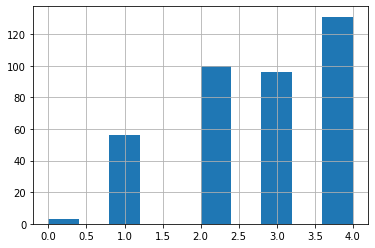

In [359]:
df.Medu.hist()

##### Распределение выглядит нормальным (без выбросов)

### 4.1.2 'Fedu' - образование отцов

In [360]:
df.Fedu.value_counts(dropna = False)

2.0     103
3.0      93
4.0      88
1.0      75
NaN      24
0.0       2
40.0      1
Name: Fedu, dtype: int64

##### Есть значение, которое явно некорректно. Значение - 40. Предполагаю, что это ошибка и значение должно быть равно 4.

In [361]:
change_this(column = 'Fedu', arg1 = 40, arg2 = 4)

In [362]:
df.Fedu.value_counts(dropna = False)

2.0    103
3.0     93
4.0     89
1.0     75
NaN     24
0.0      2
Name: Fedu, dtype: int64

##### Имеем 24 пропуска

In [363]:
df[['Medu', 'Fedu']].corr()

,Medu,Fedu
Medu,1.000000,0.624543
Fedu,0.624543,1.000000


##### Fedu довльно сильно скоррелировано с Medu. Заполним пропуски через модовские значения Medu

In [364]:
mode_change(df, 'Fedu', 'Medu')

21 nan  ->  4.0
42 nan  ->  4.0
46 nan  ->  3.0
57 nan  ->  4.0
58 nan  ->  1.0
67 nan  ->  3.0
137 nan  ->  3.0
142 nan  ->  4.0
159 nan  ->  3.0
161 nan  ->  3.0
180 nan  ->  4.0
195 nan  ->  2.0
232 nan  ->  4.0
236 nan  ->  2.0
259 nan  ->  2.0
280 nan  ->  4.0
281 nan  ->  3.0
286 nan  ->  2.0
287 nan  ->  1.0
290 nan  ->  4.0
310 nan  ->  1.0
328 nan  ->  4.0
349 nan  ->  3.0
374 nan  ->  4.0


In [365]:
df[['Medu', 'Fedu']].corr()

,Medu,Fedu
Medu,1.000000,0.647106
Fedu,0.647106,1.000000


In [366]:
df.Fedu.value_counts(dropna = False)

2.0    107
3.0    100
4.0     99
1.0     78
0.0      2
Name: Fedu, dtype: int64

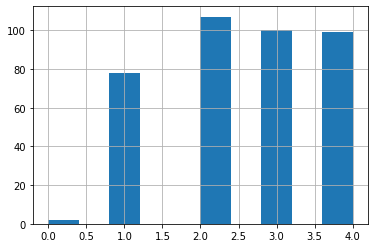

In [367]:
df.Fedu.hist()

#### Пропуски заполнены. График распределения без выбросов.

### 4.2.4 'traveltime' - время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [368]:
df.traveltime.value_counts(dropna = False)

1.0    237
2.0     93
NaN     28
3.0     21
4.0      7
Name: traveltime, dtype: int64

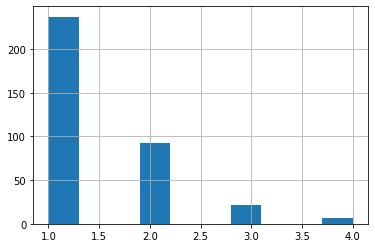

In [369]:
df.traveltime.hist()

#### Имеем 28 пропусков, в остальном распределение кажется нормальным.

In [370]:
df[rank_columns + num_columns].corr()

,famsize,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,health,age,absences,score,failures
famsize,1.000000,0.067521,0.115579,-0.050200,0.085358,0.021847,-0.020317,-0.026158,0.047812,-0.025705,-0.022409,-0.067196,-0.004488
Medu,0.067521,1.000000,0.647106,-0.166724,0.080213,-0.001465,0.039686,0.069927,-0.044021,-0.146000,0.108950,0.220311,-0.239084
Fedu,0.115579,0.647106,1.000000,-0.128635,0.008895,-0.004016,0.001054,0.061222,0.034254,-0.157204,0.066142,0.136716,-0.257594
traveltime,-0.050200,-0.166724,-0.128635,1.000000,-0.106190,-0.029468,-0.018472,0.035386,-0.014279,0.075437,-0.028904,-0.068226,0.047989
studytime,0.085358,0.080213,0.008895,-0.106190,1.000000,0.046498,-0.126573,-0.054699,-0.079237,-0.018066,-0.067890,0.116182,-0.172130
famrel,0.021847,-0.001465,-0.004016,-0.029468,0.046498,1.000000,0.169244,0.063589,0.077436,0.049916,-0.051014,0.067082,-0.053118
freetime,-0.020317,0.039686,0.001054,-0.018472,-0.126573,0.169244,1.000000,0.286124,0.069828,0.009784,-0.016713,0.019789,0.075215
goout,-0.026158,0.069927,0.061222,0.035386,-0.054699,0.063589,0.286124,1.000000,-0.015529,0.120651,0.081597,-0.125199,0.093364
health,0.047812,-0.044021,0.034254,-0.014279,-0.079237,0.077436,0.069828,-0.015529,1.000000,-0.074919,-0.043981,-0.068139,0.084553
age,-0.025705,-0.146000,-0.157204,0.075437,-0.018066,0.049916,0.009784,0.120651,-0.074919,1.000000,0.161288,-0.152866,0.194331


##### Явных корреляций не выявлено и заполнить эти пропуски не представляется возможным. Возможно стоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции.

### 4.2.5. 'studytime' - время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [371]:
df.studytime.value_counts(dropna = False)

2.0    186
1.0    103
3.0     63
4.0     27
NaN      7
Name: studytime, dtype: int64

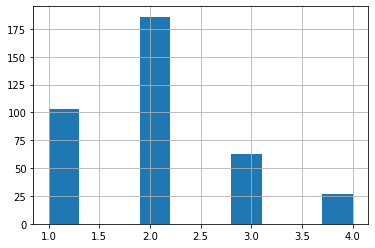

In [372]:
df.studytime.hist()

##### Довольно плавное распределение и всего лишь 7 пропусков. Заполним пропуски модой

In [373]:
mode_change(df, 'studytime', 'studytime')

17 nan  ->  2.0
91 nan  ->  2.0
112 nan  ->  2.0
129 nan  ->  2.0
227 nan  ->  2.0
266 nan  ->  2.0
314 nan  ->  2.0


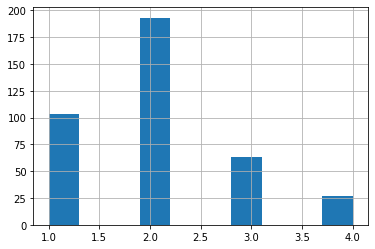

In [374]:
df.studytime.hist()

### 4.2.6. 'famrel' -  семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [375]:
df.famrel.value_counts(dropna = False)

 4.0    178
 5.0     96
 3.0     62
 NaN     26
 2.0     16
 1.0      7
-1.0      1
Name: famrel, dtype: int64

##### Значение "-1" - явная опечатка, заменим его на "1"

In [376]:
change_this('famrel', -1, 1)

In [377]:
df.famrel.value_counts(dropna = False)

4.0    178
5.0     96
3.0     62
NaN     26
2.0     16
1.0      8
Name: famrel, dtype: int64

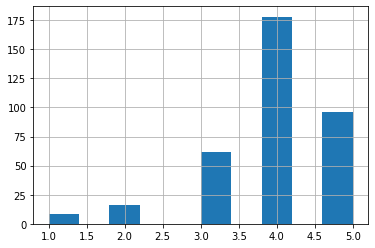

In [378]:
df.famrel.hist()

##### Имеем 26 пропусков. Заполнить эти пропуски не представляется возможным. Возможно стоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции.

### 4.2.7. 'freetime' - свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [379]:
df.freetime.value_counts(dropna = False)

3.0    151
4.0    110
2.0     63
5.0     36
1.0     17
NaN      9
Name: freetime, dtype: int64

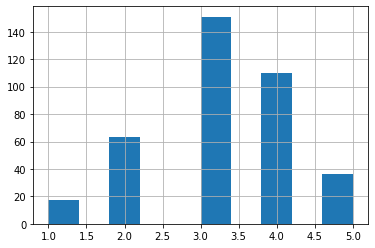

In [380]:
df.freetime.hist()

##### Довольно плавное распределение и всего лишь 9 пропусков. Заполним пропуски модой

In [381]:
mode_change(df, 'freetime', 'freetime')

32 nan  ->  3.0
74 nan  ->  3.0
131 nan  ->  3.0
280 nan  ->  3.0
290 nan  ->  3.0
291 nan  ->  3.0
311 nan  ->  3.0
314 nan  ->  3.0
338 nan  ->  3.0


### 4.2.8. 'goout' - проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [382]:
df.goout.value_counts(dropna = False)

3.0    126
2.0    101
4.0     80
5.0     51
1.0     21
NaN      7
Name: goout, dtype: int64

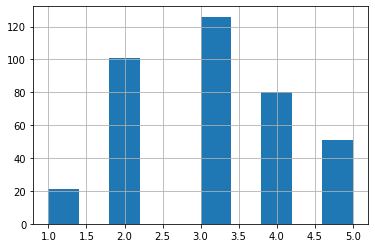

In [383]:
df.goout.hist()

##### Довольно плавное распределение и всего лишь 7 пропусков. Заполним пропуски модой

In [384]:
mode_change(df, 'goout', 'goout')

89 nan  ->  3.0
92 nan  ->  3.0
200 nan  ->  3.0
202 nan  ->  3.0
221 nan  ->  3.0
241 nan  ->  3.0
322 nan  ->  3.0


### 4.2.9. 'health' - текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [385]:
df.health.value_counts(dropna = False)

5.0    136
3.0     87
4.0     59
1.0     47
2.0     42
NaN     15
Name: health, dtype: int64

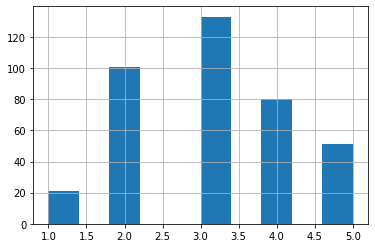

In [386]:
df.goout.hist()

##### Имеем 15 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции.

### 4.2.10. 'sex'  - пол ученика ('F' - женский, 'M' - мужской)

In [387]:
df.sex.value_counts(dropna = False)

F    202
M    184
Name: sex, dtype: int64

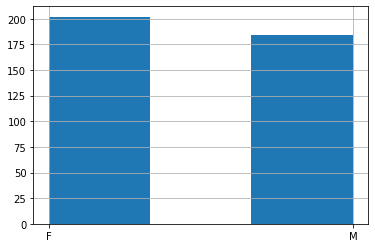

In [388]:
df.sex.hist(bins = 3)

##### Пропусков нет. Заменим F на '0', а M на '1'

In [389]:
change_this('sex', 'F', 0)

In [390]:
change_this('sex', 'M', 1)

In [391]:
df.sex.value_counts(dropna = False)

0    202
1    184
Name: sex, dtype: int64

### 4.2.11. 'romantic' - в романтических отношениях (yes или no)

In [392]:
df.romantic.value_counts(dropna = False)

no     233
yes    122
NaN     31
Name: romantic, dtype: int64

##### Заменим 'yes' на 1, а 'no' на 0 

In [393]:
change_this('romantic', 'yes', 1)

In [394]:
change_this('romantic', 'no', 0)

In [395]:
df.romantic.value_counts(dropna = False)

0.0    233
1.0    122
NaN     31
Name: romantic, dtype: int64

##### Имеем 31 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции.

### 4.2.12. 'school' - аббревиатура школы, в которой учится ученик

In [396]:
df.school.value_counts(dropna = False)

GP    342
MS     44
Name: school, dtype: int64

In [397]:
change_this('school', 'GP', 1)
change_this('school', 'MS', 0)

##### Пропусков нет. Заменим на 0 и 1

In [398]:
df.school.value_counts(dropna = False)

1    342
0     44
Name: school, dtype: int64

### 4.2.13. 'higher' - хочет получить высшее образование (yes или no)

In [399]:
df.higher.value_counts(dropna = False)

yes    348
NaN     20
no      18
Name: higher, dtype: int64

##### Заменим 'yes' на 1, а 'no' на 0 

In [400]:
change_this('higher', 'yes', 1)
change_this('higher', 'no', 0)

In [401]:
df.higher.value_counts(dropna = False)

1.0    348
NaN     20
0.0     18
Name: higher, dtype: int64

###### Имеем 18 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции.

### 4.2.14. 'schoolsup' - дополнительная образовательная поддержка (yes или no)

In [402]:
col = 'schoolsup'

In [403]:
df[col].value_counts(dropna = False)

no     329
yes     48
NaN      9
Name: schoolsup, dtype: int64

In [404]:
percent(48,(329+48))

'12.7%'

In [405]:
##### Заменим 'yes' на 1, а 'no' на 0
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

In [406]:
df[df[col] == 1].score.mean()

46.25

In [407]:
df[df[col] == 0].score.mean()

53.17629179331307

In [408]:
percent(df[(df[col].isnull()) & (df['score'] < 30)].score.count(),9)

'11.1%'

#### Заменим пропуски примерно в исходной пропорции следующим образом: ученики у которых менее 30 баллов за экзамен имееют доп. поддержку, остальные нет.

##### Видимо дополнительной образовательной поддержкой пользуются те у кого трудности в обучении

In [409]:
df[[col,'score']][df[col].isnull()]

,schoolsup,score
27,NaN,75.0
35,NaN,30.0
79,NaN,25.0
151,NaN,70.0
211,NaN,65.0
274,NaN,50.0
321,NaN,45.0
392,NaN,35.0
394,NaN,45.0


In [410]:
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

In [411]:
df[(df[col].isnull()) & (df['score'] < 30)].score

79    25.0
Name: score, dtype: float64

In [412]:
df.loc[79, col] = 1

In [413]:
ind = df[(df[col].isnull()) & (df['score'] >= 30)].score.index

In [414]:
for i in ind:
    df.loc[i, col] = 0

In [415]:
df[col].value_counts(dropna = False)

0.0    337
1.0     49
Name: schoolsup, dtype: int64

In [416]:
percent(49,(337+49))

'12.7%'

### 4.2.15. 'guardian' - опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [417]:
col = 'guardian'

In [418]:
df[col].value_counts(dropna = False)

mother    246
father     86
NaN        30
other      24
Name: guardian, dtype: int64

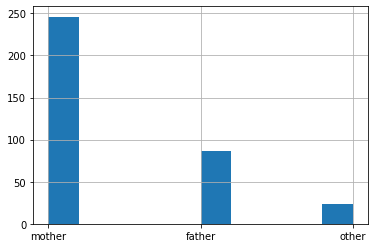

In [419]:
df[col].hist()

##### Имеем 30 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции

### 4.2.15. 'Mjob' - работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [420]:
col = 'Mjob'

In [421]:
df[col].value_counts(dropna = False)

other       126
services     96
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64

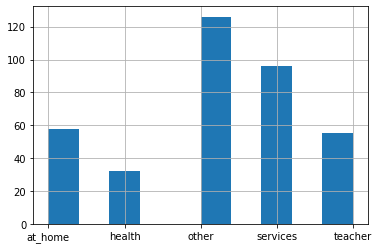

In [422]:
df[col].hist()

##### Имеем 19 пропусков. Заполним пропуски в зависимости от образования (на моды).

In [423]:
mode_change(df, col, 'Medu')

29 None  ->  teacher
54 None  ->  services
59 None  ->  teacher
88 None  ->  other
104 None  ->  services
128 None  ->  other
145 None  ->  at_home
156 None  ->  at_home
166 None  ->  other
174 None  ->  services
177 None  ->  services
219 None  ->  other
224 None  ->  teacher
260 None  ->  teacher
265 None  ->  services
268 None  ->  teacher
277 None  ->  teacher
291 None  ->  teacher
337 None  ->  services


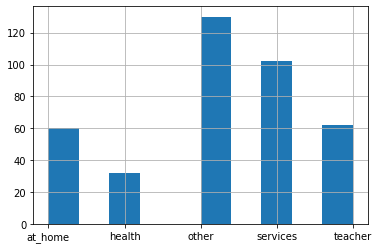

In [424]:
df[col].hist()

##### Качественно график не изменился. Отлично

### 4.2.15. 'Fjob' - работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [425]:
col = 'Fjob'

In [426]:
df[col].value_counts(dropna = False)

other       194
services     97
NaN          36
teacher      28
at_home      16
health       15
Name: Fjob, dtype: int64

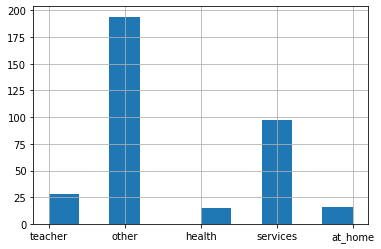

In [427]:
df[col].hist()

##### Имеем 36 пропусков. Заполним пропуски в зависимости от образования (на моды).

In [428]:
mode_change(df, col, 'Fedu')

3 None  ->  other
17 None  ->  other
22 None  ->  other
26 None  ->  other
31 None  ->  other
44 None  ->  other
47 None  ->  other
52 None  ->  other
59 None  ->  other
68 None  ->  other
107 None  ->  other
118 None  ->  other
120 None  ->  other
135 None  ->  other
151 None  ->  other
152 None  ->  other
160 None  ->  other
161 None  ->  other
169 None  ->  other
182 None  ->  other
216 None  ->  other
229 None  ->  other
250 None  ->  other
266 None  ->  other
294 None  ->  other
303 None  ->  other
309 None  ->  other
316 None  ->  other
336 None  ->  other
341 None  ->  other
345 None  ->  other
363 None  ->  other
365 None  ->  other
373 None  ->  other
374 None  ->  other
384 None  ->  other


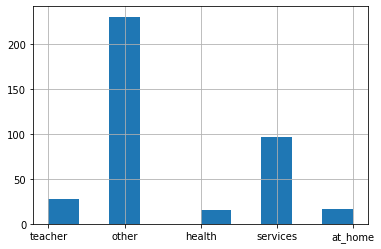

In [429]:
df[col].hist()

##### Качественно график не изменился. Отлично

### 4.2.16. 'address' - тип адреса ученика ('U' - городской, 'R' - за городом)

In [461]:
col = 'address'

In [431]:
df[col].value_counts(dropna = False)

U      289
R       82
NaN     15
Name: address, dtype: int64

In [432]:
percent(82,82+289)

'22.1%'

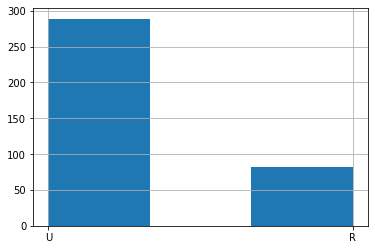

In [433]:
df[col].hist(bins = 3)

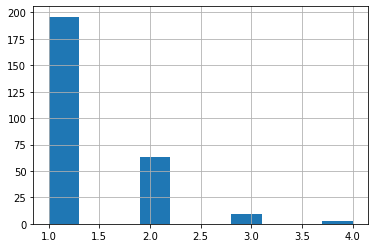

In [434]:
df[[col, 'traveltime']][df[col] == 'U'].traveltime.hist()

In [435]:
df[[col, 'traveltime']][df[col] == 'U'].traveltime.mean()

1.3321033210332103

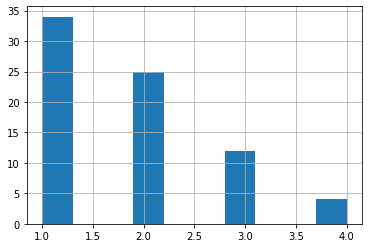

In [436]:
df[[col, 'traveltime']][df[col] == 'R'].traveltime.hist()

In [437]:
df[[col, 'traveltime']][df[col] == 'R'].traveltime.mean()

1.8133333333333332

##### Характеры распределений времени у школьников живущих в городе и за городом примерно похожи. Но ученики в городе в среднем добираются до школы быстрее.

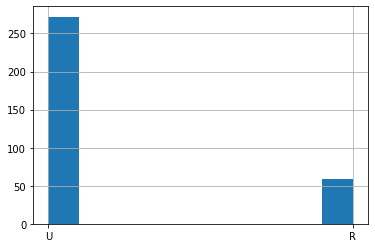

In [447]:
df[df['school'] == 1][col].hist()

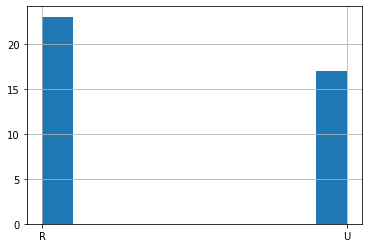

In [448]:
df[df['school'] == 0][col].hist()

##### Почти все ученики школы 'GP' (1) живут в городе. Заменим пропуски среди учеников этой школы на U. 

In [440]:
df[(df['address'].isnull())&(df['school'] == 1)][['address', 'school']]

,address,school
6,None,1
52,None,1
75,None,1
92,None,1
96,None,1
159,None,1
168,None,1
241,None,1
254,None,1
292,None,1


In [441]:
def spec_change(df, A, a, B, b):
       
    #разбираемся с пропусками в А, где в B пропусков нет
    index = [x[0] for x in df[(df[A].isnull())&(df[B] == b)].iterrows()]
         
    for i in index:
        print(i, df.loc[i, A],' -> ', a)
        df.loc[i, A] = a


In [449]:
spec_change(df, 'address', 'U', 'school', 1)

6 None  ->  U
52 None  ->  U
75 None  ->  U
92 None  ->  U
96 None  ->  U
159 None  ->  U
168 None  ->  U
241 None  ->  U
254 None  ->  U
292 None  ->  U
348 None  ->  U


In [450]:
df[col].value_counts(dropna = False)

U      300
R       82
NaN      4
Name: address, dtype: int64

##### Остальные 4 ученика учаться в другой школе. Посмотрим на их данные

In [451]:
df[df[col].isnull()][[col, 'traveltime']]

,address,traveltime
354,None,2.0
359,None,2.0
372,None,NaN
376,None,2.0


#### Заменим два значения на U и два на R

In [456]:
df.loc[354, 'address'] = 'U'
df.loc[359, 'address'] = 'U'
df.loc[372, 'address'] = 'R'
df.loc[376, 'address'] = 'R'

In [458]:
df[col].value_counts(dropna = False)

U    302
R     84
Name: address, dtype: int64

In [462]:
change_this(col, 'U', 1)
change_this(col, 'R', 0)

In [463]:
df[col].value_counts(dropna = False)

1    302
0     84
Name: address, dtype: int64

### 4.2.17. 'internet' - наличие интернета дома (yes или no)

In [464]:
col = 'internet'

In [465]:
df[col].value_counts(dropna = False)

yes    298
no      54
NaN     34
Name: internet, dtype: int64

In [466]:
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

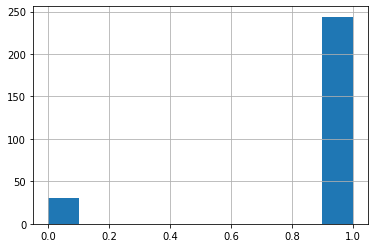

In [468]:
df[df.address == 1].internet.hist()

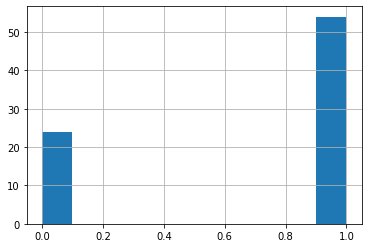

In [469]:
df[df.address == 0].internet.hist()

##### У проживающих в городе есть интернет у подавляющего болшиства. Можем заменить пропуски городских на 1

In [470]:
spec_change(df, 'internet', '1', 'address', 1)

0 nan  ->  1
12 nan  ->  1
52 nan  ->  1
65 nan  ->  1
80 nan  ->  1
86 nan  ->  1
98 nan  ->  1
110 nan  ->  1
115 nan  ->  1
117 nan  ->  1
125 nan  ->  1
132 nan  ->  1
133 nan  ->  1
141 nan  ->  1
162 nan  ->  1
185 nan  ->  1
191 nan  ->  1
194 nan  ->  1
198 nan  ->  1
215 nan  ->  1
239 nan  ->  1
251 nan  ->  1
257 nan  ->  1
258 nan  ->  1
259 nan  ->  1
333 nan  ->  1
340 nan  ->  1
389 nan  ->  1


In [471]:
df[col].value_counts(dropna = False)

1.0    298
0.0     54
1       28
NaN      6
Name: internet, dtype: int64

In [473]:
df[df[col].isnull()][[col, 'address', 'score']]

,internet,address,score
118,NaN,0,40.0
155,NaN,0,40.0
273,NaN,0,70.0
308,NaN,0,60.0
384,NaN,0,25.0
385,NaN,0,50.0


##### Заменим 2 значение на отсутсвтие интернета и 4 за его наличие

In [474]:
df.loc[118, 'internet'] = 0
df.loc[155, 'internet'] = 1
df.loc[273, 'internet'] = 1
df.loc[308, 'internet'] = 1
df.loc[384, 'internet'] = 0
df.loc[385, 'internet'] = 1

In [476]:
df[df[col].isnull()][[col, 'address', 'score']]

,internet,address,score


### 4.2.18. 'famsup' - семейная образовательная поддержка (yes или no)

In [477]:
col = 'famsup'
df[col].value_counts(dropna = False)

yes    215
no     135
NaN     36
Name: famsup, dtype: int64

In [478]:
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

##### Довольно много пропусков. Пока оставим без аполнения

### 4.2.18. 'activities' - дополнительные внеучебные занятия (yes или no)

In [479]:
col = 'activities'
df[col].value_counts(dropna = False)

yes    192
no     180
NaN     14
Name: activities, dtype: int64

In [480]:
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

##### Здесь не так много пропусков. Предполагаю, что в данном случае пропуски это скрыйты 'no'. Выполним замену.

In [481]:
df[col] = df[col].apply(lambda x: 0 if pd.isnull(x)      
                                  else x                          
                        )

In [482]:
df[col].value_counts(dropna = False)

0.0    194
1.0    192
Name: activities, dtype: int64

### 4.2.19. 'reason' - причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [483]:
col = 'reason'
df[col].value_counts(dropna = False)

course        134
reputation    102
home          100
other          33
NaN            17
Name: reason, dtype: int64

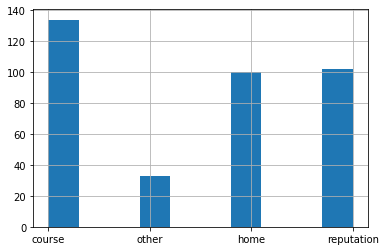

In [484]:
df[col].hist()

##### Имеем 17 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции

### 4.2.20. 'paid' - дополнительные платные занятия по математике (yes или no)

In [486]:
col = 'paid'
df[col].value_counts(dropna = False)

no     195
yes    152
NaN     39
Name: paid, dtype: int64

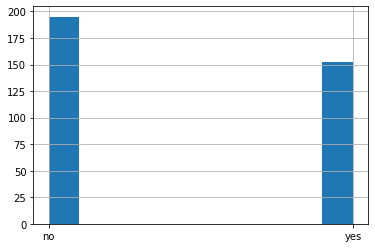

In [487]:
df[col].hist()

In [488]:
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

##### Имеем 39 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции

### 4.2.21. 'nursery' - посещал детский сад (yes или no)

In [489]:
col = 'nursery'
df[col].value_counts(dropna = False)

yes    295
no      76
NaN     15
Name: nursery, dtype: int64

In [490]:
change_this(col, 'yes', 1)
change_this(col, 'no', 0)

##### Имеем 15 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции

### 4.2.22. 'Pstatus' - статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [491]:
col = 'Pstatus'
df[col].value_counts(dropna = False)

T      307
NaN     45
A       34
Name: Pstatus, dtype: int64

In [492]:
change_this(col, 'T', 1)
change_this(col, 'A', 0)

##### Имеем 45 пропусков. Заполнить эти пропуски не представляется возможным. Cтоит рассмотреть заполнение пропусков случайными значениями в исходной пропорции

# 5. Анализ корреляций и тест Стьюдента.

##### После первичной обработки данных от выбросов, мусора и частичного заполнения выполним повторно проверки зависимостей.

In [494]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,romantic,famrel,freetime,goout,health,absences,score
school,1,0.0322204,-0.368991,0.304738,0.0493758,-0.0949425,0.124875,0.0717625,-0.250318,0.092932,-0.0293185,0.136772,0.186212,0.0352628,0.095966,0.119311,0.0394042,-0.0725563,0.0544622,-0.0193385,0.0181629,0.0304587,0.103681,0.0417922
sex,0.0322204,1,-0.0373181,0.0130918,-0.0905065,0.0441315,0.0849654,0.0523745,0.0487982,-0.306099,0.0128159,-0.130217,-0.153155,-0.109406,0.108686,0.00345992,-0.169515,-0.13133,0.0390629,0.220881,0.0822691,0.146294,-0.0618924,0.103558
age,-0.368991,-0.0373181,1,-0.166509,-0.0257053,0.0424022,-0.146,-0.157204,0.0754372,-0.0178618,0.194331,-0.25726,-0.162736,-0.0365024,-0.0715618,-0.0958685,-0.212679,0.158357,0.0479938,0.00768428,0.120589,-0.0749186,0.161288,-0.152866
address,0.304738,0.0130918,-0.166509,1,-0.0704475,-0.0860878,0.157497,0.0804503,-0.284613,-0.0593238,-0.10914,0.0313674,0.0299535,0.0484264,-0.0655186,0.0459508,0.0309351,-0.00774297,-0.0128145,0.0354324,0.0599859,-0.0345288,0.017117,0.111273
famsize,0.0493758,-0.0905065,-0.0257053,-0.0704475,1,0.0683797,0.0675212,0.115579,-0.0501995,0.0845687,-0.00448837,0.0237333,0.128719,0.0948739,0.0362372,-0.0970905,0.0348466,-0.0173856,0.0267349,-0.0215525,-0.0240726,0.0478122,-0.0224093,-0.0671955
Pstatus,-0.0949425,0.0441315,0.0424022,-0.0860878,0.0683797,1,-0.135498,-0.126884,0.0857045,0.00590223,0.0239702,-0.0504966,-0.0202142,0.0463513,0.0949553,-0.0812392,-0.0726952,-0.0424309,0.0281735,0.0522749,0.0284462,0.0176845,-0.110767,-0.0541887
Medu,0.124875,0.0849654,-0.146,0.157497,0.0675212,-0.135498,1,0.647106,-0.166724,0.0795989,-0.239084,-0.0254574,0.203945,0.175372,0.1032,0.185136,0.193987,0.0136402,-0.00584242,0.0384949,0.0693109,-0.044021,0.10895,0.220311
Fedu,0.0717625,0.0523745,-0.157204,0.0804503,0.115579,-0.126884,0.647106,1,-0.128635,0.00891456,-0.257594,0.0539705,0.216723,0.103291,0.102205,0.165109,0.189394,-0.00375529,-0.00729218,0.00105902,0.0608438,0.0342538,0.0661419,0.136716
traveltime,-0.250318,0.0487982,0.0754372,-0.284613,-0.0501995,0.0857045,-0.166724,-0.128635,1,-0.105018,0.0479894,-0.00573278,-0.0118503,-0.0372119,0.00351192,-0.039702,-0.0761233,0.0164762,-0.0346315,-0.0191964,0.0365153,-0.0142792,-0.0289041,-0.0682259
studytime,0.092932,-0.306099,-0.0178618,-0.0593238,0.0845687,0.00590223,0.0795989,0.00891456,-0.105018,1,-0.17056,0.0390399,0.127318,0.197357,0.117179,0.0901018,0.178047,0.0510701,0.0395478,-0.123483,-0.0544377,-0.0786437,-0.0675136,0.114717


##### Судя по матрице корреляций, значительная корреляция есть только между параметрами Fedu и Medu. Возможно следует заменить эти два столбца на какой-то третий столбец, основанный на этих данных. Или удалить один из этих столбцов.

In [498]:
for col in nonn_columns:
    get_stat_dif(col, 'score')

Походу столбец  score  взаимосвязан со столбцом  sex
Походу столбец  score  взаимосвязан со столбцом  romantic
Походу столбец  score  взаимосвязан со столбцом  higher
Походу столбец  score  взаимосвязан со столбцом  address
Походу столбец  score  взаимосвязан со столбцом  Medu
Походу столбец  score  взаимосвязан со столбцом  Fedu
Походу столбец  score  взаимосвязан со столбцом  schoolsup
Походу столбец  score  взаимосвязан со столбцом  Mjob


In [497]:
for col in all_columns:
    get_stat_dif(col, 'score')

Походу столбец  score  взаимосвязан со столбцом  sex
Походу столбец  score  взаимосвязан со столбцом  address
Походу столбец  score  взаимосвязан со столбцом  Medu
Походу столбец  score  взаимосвязан со столбцом  Fedu
Походу столбец  score  взаимосвязан со столбцом  Mjob
Походу столбец  score  взаимосвязан со столбцом  failures
Походу столбец  score  взаимосвязан со столбцом  schoolsup
Походу столбец  score  взаимосвязан со столбцом  higher
Походу столбец  score  взаимосвязан со столбцом  romantic
Походу столбец  score  взаимосвязан со столбцом  score


##### Следует принять для нашей модели за основу параметры из данных столбцов, полученных по тесту Стьюдента, а также все колличественные параметры.

##### Дата редактирования: 13.05.2020